In [1]:
import swifter
import re
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import emoji
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

## Tổng quan về data

In [2]:
data = pd.read_csv("Combined_data.csv", usecols=["text", "label", "length_text"])

In [3]:
data.head()

,text,label,length_text
0,The head of a conservative Republican faction ...,True,746
1,Transgender people will be allowed for the fir...,True,396
2,The special counsel investigation of links bet...,True,454
3,Trump campaign adviser George Papadopoulos tol...,True,373
4,President Donald Trump called on the U.S. Post...,True,849


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78588 entries, 0 to 78587
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         78588 non-null  object
 1   label        78588 non-null  bool  
 2   length_text  78588 non-null  int64 
dtypes: bool(1), int64(1), object(1)
memory usage: 1.3+ MB


In [5]:
data.loc[0, "text"]

'The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific researc

## Phân tích chi tiết

### Độ dài của văn bản và tỉ lệ nhãn

In [6]:
data['length_text'].describe()

count    78588.000000
mean       479.603705
std        613.279250
min          1.000000
25%        137.000000
50%        351.000000
75%        593.000000
max      24234.000000
Name: length_text, dtype: float64

In [7]:
data.sort_values(by=["length_text"]).text

46393                                               Enjoy:
50076    https://100percentfedup.com/12-yr-old-black-co...
53414          https://www.youtube.com/watch?v=P-TBfkqk7gU
46327          https://www.youtube.com/watch?v=yRXmFmgoPTk
46219          https://www.youtube.com/watch?v=-7Tn4gi_Os8
                               ...                        
62091    How Many People Will Have To Migrate Out Of Ca...
67576    Заседание Международного дискуссионного клуба ...
70418    Why Are So Many People Choosing To Leave The U...
61511    Why Are So Many People Choosing To Leave The U...
64484    The Hard Working American vs. The Government P...
Name: text, Length: 78588, dtype: object

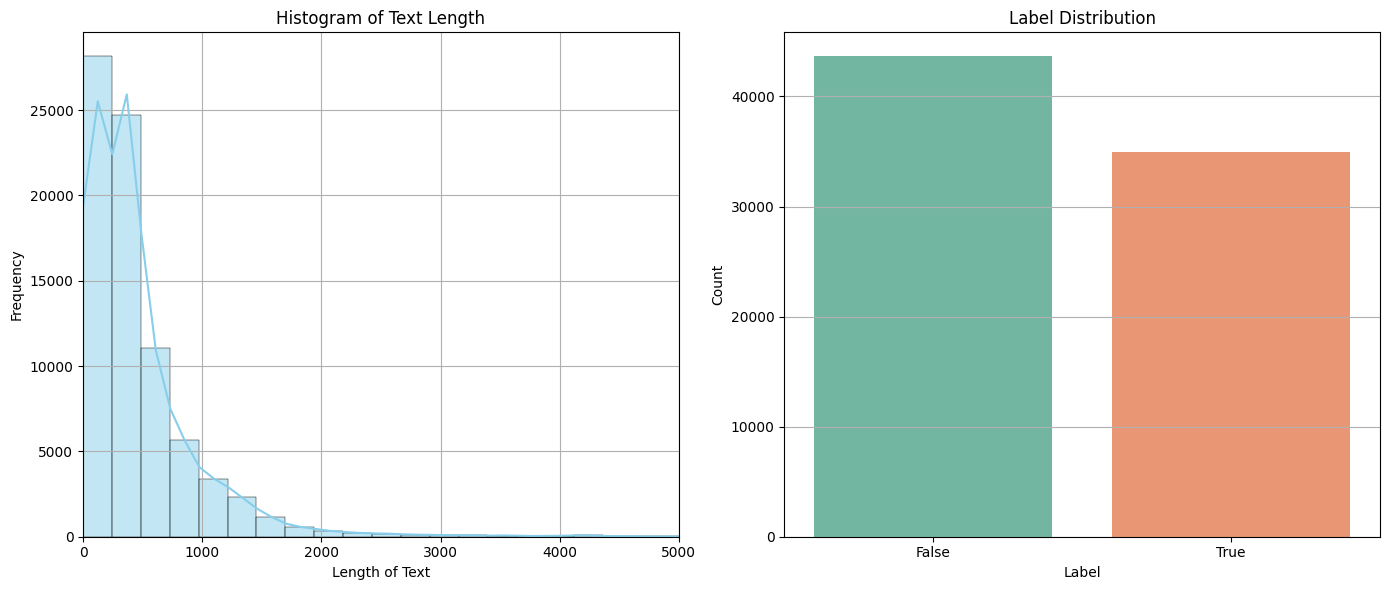

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Histogram cho lenght_text
sns.histplot(data['length_text'], bins=100, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title("Histogram of Text Length")
ax[0].set_xlabel("Length of Text")
ax[0].set_xlim([0,5000])
ax[0].set_ylabel("Frequency")
ax[0].grid(True)

# Bar chart cho label
sns.countplot(x='label', data=data, palette='Set2', ax=ax[1])
ax[1].set_title("Label Distribution")
ax[1].set_xlabel("Label")
ax[1].set_ylabel("Count")
ax[1].grid(True, axis='y')

plt.tight_layout()
plt.show()


In [9]:
lenght_stats =  data.groupby("label")["length_text"].agg(["mean", "median"]).reset_index()
lenght_stats

,label,mean,median
0,False,436.378512,326.0
1,True,533.585103,389.0


So sánh tỉ lệ nhãn theo độ dài của văn bản

In [10]:
length_label_counts = pd.crosstab(data['length_text'], data['label'])
false_to_true_ratio = length_label_counts[False] / (length_label_counts[True]+1)
false_to_true_ratio

length_text
1        23.200000
2        12.666667
3        14.000000
4         9.666667
5        27.500000
           ...    
17427     1.000000
20084     1.000000
20876     1.000000
20891     2.000000
24234     1.000000
Length: 2901, dtype: float64

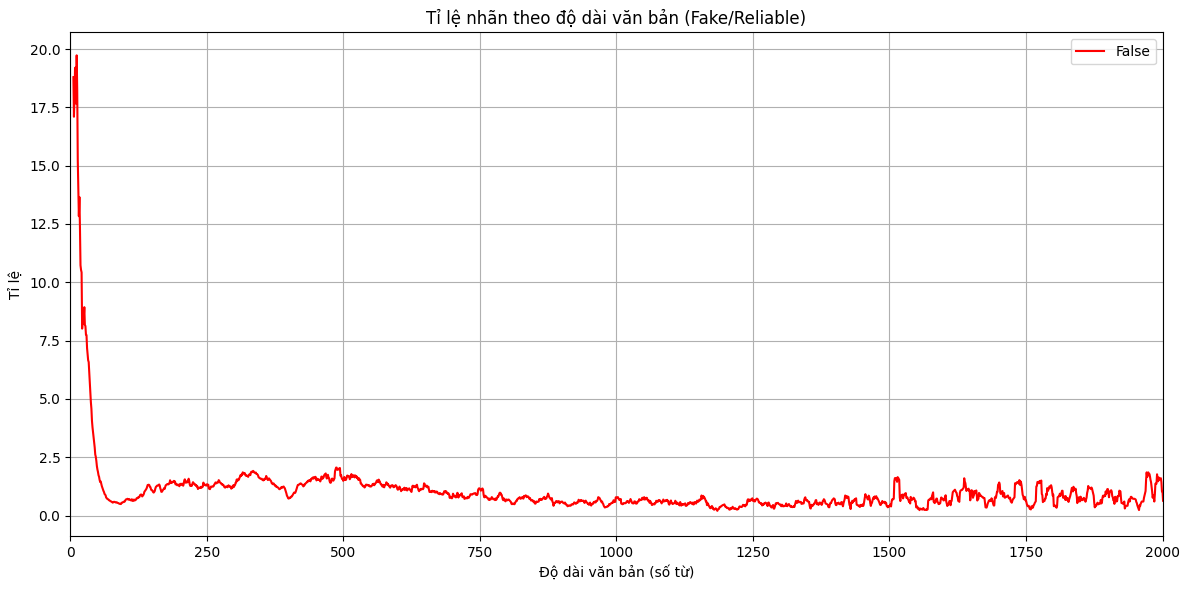

In [11]:
# Làm mượt dựa trên tính trung bình của 10 độ dài cùng nhau
smoothed_ratio = false_to_true_ratio.rolling(window=10, center=True).mean()


plt.figure(figsize=(12, 6))
sns.lineplot(data=smoothed_ratio, label='False', color='red')
plt.title('Tỉ lệ nhãn theo độ dài văn bản (Fake/Reliable)')
plt.xlabel('Độ dài văn bản (số từ)')
plt.xlim([0,2000])
plt.ylabel('Tỉ lệ')
plt.grid(True)
plt.tight_layout()
plt.show()


- Số các ký tự trong văn bản trải rộng từ 1 đến hơn 24000 từ.

- Tuy nhiên, dự liệu về length_text đang **lệch trái**. Do đó, ta có thể thấy phần lớn các văn bản có độ dài dưới 2000 từ

- Ta có thể thấy, với Reliable News thì nội dung thường được viết dài hơn và chỉnh chu hơn.

- Ở những văn bản có độ dài khoảng dưới 100 từ thì đa số đều là những thông tin không đáng tin cậy, ta có thấy sự vào biểu đồ tỉ lệ Fake/Reliable dựa trên số từ

### Độ dài của chữ

Pandas Apply:   0%|          | 0/78588 [00:00<?, ?it/s]

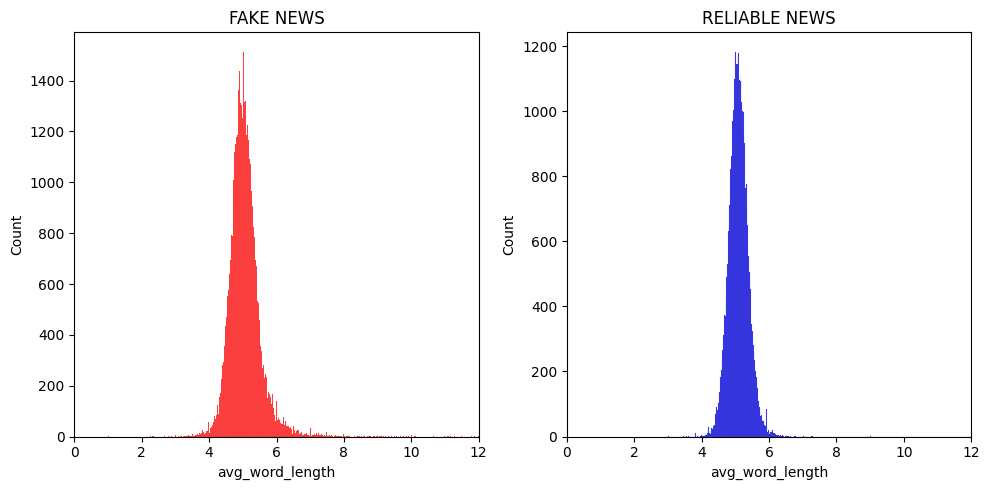

In [12]:
# Tạo cột mới: độ dài trung bình của từ trong mỗi văn bản
data['avg_word_length'] = data['text'].swifter.apply(lambda x: np.mean([len(word) for word in x.split()]))

# Vẽ histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data[data['label'] == False]['avg_word_length'], ax=ax1, color='red')
ax1.set_title('FAKE NEWS')
ax1.set_xlim([0,12])
sns.histplot(data[data['label'] == True]['avg_word_length'], ax=ax2, color='blue')
ax2.set_title('RELIABLE NEWS')
ax2.set_xlim([0,12])

plt.tight_layout()
plt.show()

Độ dài trung bìnhcủa chữ trong cả fake news và reliable news là khá tương đồng nhau, nên cũng khó có thể phân biệt được dựa vào yếu tố này

### Emojis

In [13]:
def count_emojis_in_text(text):
    """
    Đếm emoji trong một chuỗi văn bản
    """
    return [char for char in text if char in emoji.EMOJI_DATA]
def average_emoji_count_by_label(data, label_column='label', text_column='text'):
    """
    Tính số lượng emoji trung bình trong mỗi văn bản, theo từng nhãn.
    """
    avg_counts = {}
    for label_value in data[label_column].unique():
        subset = data[data[label_column] == label_value]
        emoji_counts = subset[text_column].apply(lambda text: len(count_emojis_in_text(text)))
        avg = emoji_counts.mean()
        avg_counts[label_value] = avg
    return avg_counts

In [14]:
avg_emoji_counts = average_emoji_count_by_label(data)
for label, avg in avg_emoji_counts.items():
    print(f"Label = {label}: Trung bình {avg:.2f} emoji / văn bản")


Label = True: Trung bình 0.01 emoji / văn bản
Label = False: Trung bình 0.03 emoji / văn bản


Chúng ta có thể thấy, số lượng emojis được sử dụng là không nhiều, dù là Fake News hay Reliable News thì trong **100 văn bản** chỉ xuất hiện khoảng từ **1-3 emojis**.

=> Do đó ta sẽ loại bỏ các emojis này vì chúng không mang nhiều ý nghĩa quyết định độ xác thực của 1 thông tin

### Các từ xuất hiện nhiều nhất theo nhãn

Để chính xác hơn ta sẽ tiền xử lý dữ liệu (loại bỏ stopwords, stemming, loại bỏ url và các token không phải chữ)

In [ ]:
# Chỉ chạy nếu chưa download
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nhatnamdo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [42]:
def preprocess_text(text):
    """
    Làm sạch văn bản: loại URL, lowercase, tokenize, loại stopwords, dấu câu và lemmatize.
    """
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    # Loại URL và đưa về chữ thường
    text = re.sub(r"http\S+|www\S+", "", text.lower())

    # Tokenize
    tokens = word_tokenize(text)
    # Loại dấu câu, số, stopwords, và lemmatize
    clean_tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok.isalpha() and tok not in stop_words and tok not in string.punctuation
    ]

    return " ".join(clean_tokens)


def get_top_ngrams_by_label(data, label_column='label', text_column='text', ngram=1, top_k=10):
    """
    Trả về top_k n-gram theo từng label.
    """
    top_ngrams = {}

    for label in sorted(data[label_column].unique()):
        subset = data[data[label_column] == label]
        clean_texts = subset[text_column].apply(preprocess_text)

        vec = CountVectorizer(ngram_range=(ngram, ngram), binary=True)
        X = vec.fit_transform(clean_texts)

        total_counts = np.asarray(X.sum(axis=0)).reshape(-1)
        vocab = vec.get_feature_names_out()
        freq = dict(zip(vocab, total_counts))
        top = Counter(freq).most_common(top_k)

        top_ngrams[label] = pd.DataFrame(top, columns=['ngram', 'count'])

    return top_ngrams

def plot_top_ngrams_by_label(top_ngrams_dict):
    """
    Vẽ biểu đồ bar cho top n-grams theo từng label.
    """
    n = len(top_ngrams_dict)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 4), constrained_layout=True)
    if n == 1:
        axes = [axes]

    for ax, (label, df_top) in zip(axes, top_ngrams_dict.items()):
        sns.barplot(data=df_top, x='ngram', y='count', ax=ax, palette='muted')
        ax.set_title(f"Label = {label}")
        ax.set_xlabel("N-gram")
        ax.set_ylabel("Tần suất")
        ax.tick_params(axis='x', rotation=45)
    
    plt.show()


Áp dụng với 1-gram

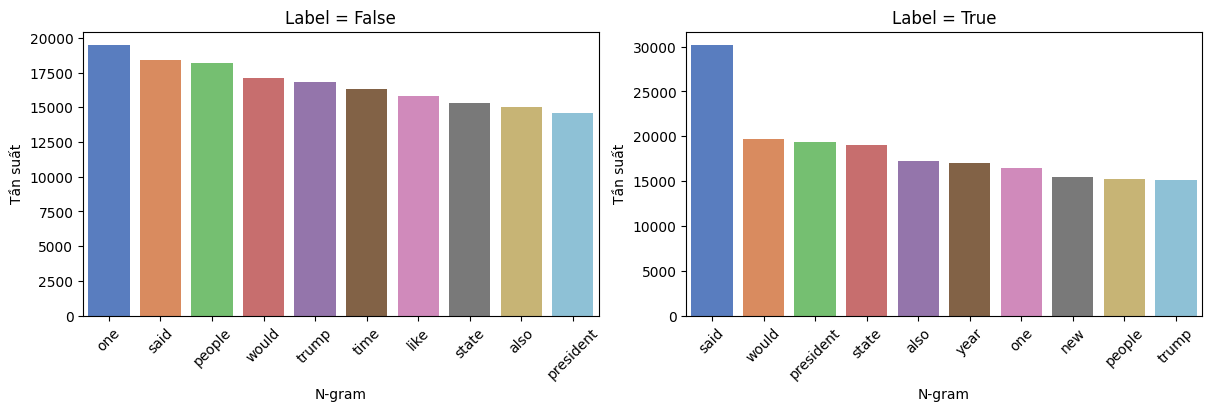

In [43]:
top_ngrams = get_top_ngrams_by_label(data, ngram=1, top_k=10)
plot_top_ngrams_by_label(top_ngrams)

Áp dụng với 2-gram

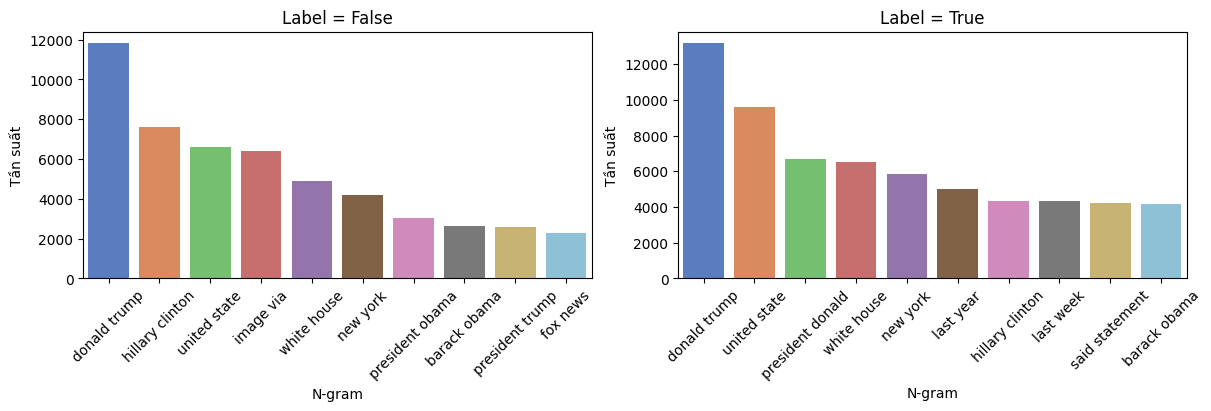

In [44]:
top_ngrams = get_top_ngrams_by_label(data, ngram=2, top_k=10)  # bigram
plot_top_ngrams_by_label(top_ngrams)

Áp dụng với 3-gram

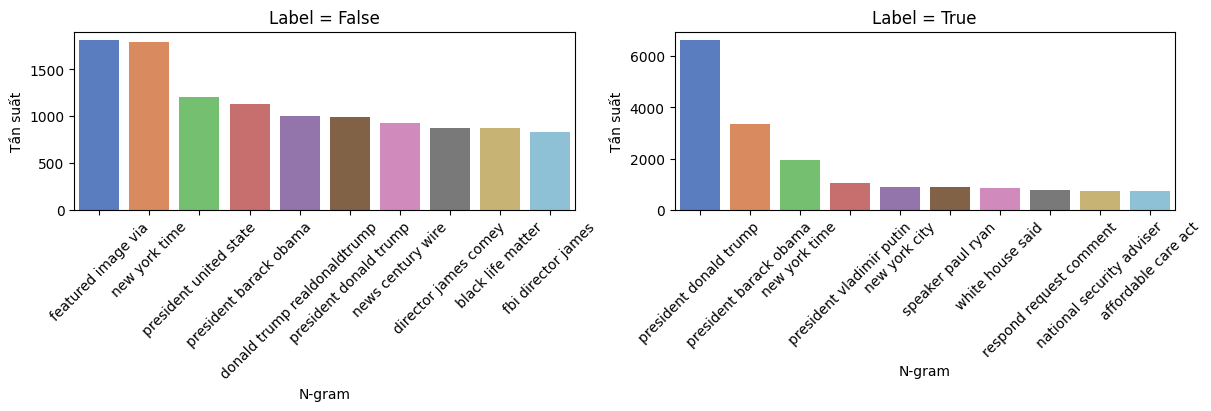

In [45]:
top_ngrams = get_top_ngrams_by_label(data, ngram=3, top_k=10)  # trigram
plot_top_ngrams_by_label(top_ngrams)